# View Simulated atmospheric transparency

In [38]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as plt3d
import numpy as np
import os,sys
import re
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cmx
import pandas as pd
import itertools

from astropy import units as u
from astropy.coordinates import Angle

import time
from datetime import datetime,date
import dateutil.parser
import pytz

import argparse

import logging
import coloredlogs
import configparser


In [39]:
from astropy.io import fits

In [40]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10,6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [41]:
os.getenv('LIBRADTRANDIR')

'/Users/dagoret/MacOSX/External/libRadtran2'

In [42]:
sys.path.append('../libradtran')

In [43]:
import libsimulateVisible

# Initialisation

In [44]:
# date
today = date.today()
string_date = today.strftime("%Y-%m-%d")


# time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")

tim = time.localtime()
current_time = time.strftime("%H:%M:%S", tim)


#timezones
tz_LA = pytz.timezone('America/Los_Angeles')
datetime_LA = datetime.now(tz_LA)
print("LA time:", datetime_LA.strftime("%H:%M:%S"))


tz_NY = pytz.timezone('America/New_York')
datetime_NY = datetime.now(tz_NY)
print("NY time:", datetime_NY.strftime("%H:%M:%S"))

tz_London = pytz.timezone('Europe/London')
datetime_London = datetime.now(tz_London)
print("London time:", datetime_London.strftime("%H:%M:%S"))

tz_Paris = pytz.timezone('Europe/Paris')
datetime_Paris = datetime.now(tz_Paris)
print("Paris time:", datetime_Paris.strftime("%H:%M:%S"))



LA time: 06:10:01
NY time: 09:10:01
London time: 14:10:01
Paris time: 15:10:01


In [45]:
# start with logs
#-----------------
logging.basicConfig()
logging.root.setLevel(logging.NOTSET)

handle = __name__

logger = logging.getLogger(handle)
# logging.getLogger().setLevel(logging.INFO)
logger.setLevel(logging.DEBUG)

# If you don't want to see log messages from libraries, you can pass a
# specific logger object to the install() function. In this case only log
# messages originating from that logger will show up on the terminal.
coloredlogs.install(level='DEBUG', logger=logger)
coloredlogs.install(fmt='%(asctime)s,%(msecs)03d %(hostname)s %(name)s[%(process)d] %(levelname)s %(message)s')

In [46]:
# arguments
#----------

parser = argparse.ArgumentParser()
parser.add_argument("--config",action="store", dest="configfile",help=f" run generate -config configfilename, with by ex configfilename = default.ini")
#results_args = parser.parse_args()

results_args=""
   

In [47]:
msg = f"Start {parser.prog} at date : {string_date} and time :{current_time} and with arguments:{results_args}"
logger.info(msg)

2020-09-15 15:10:01,776 MacBook-Pro-de-admin.local __main__[40806] INFO Start ipykernel_launcher.py at date : 2020-09-15 and time :15:10:01 and with arguments:


# Configuration

In [48]:
# config file
# --------------
configfile = "config/default.ini"
packetnum =100
#config_filename = results_args.configfile
config_filename = configfile
msg = f"Configuration file : {config_filename}"
logger.info(msg)

2020-09-15 15:10:01,787 MacBook-Pro-de-admin.local __main__[40806] INFO Configuration file : config/default.ini


In [49]:
#packet_str=str(packetnum).zfill(4)

In [50]:
#packet_str

In [51]:
# 1) CONFIGURATION
#------------------
logger.info('1) Configuration')

config = configparser.ConfigParser()

if os.path.exists(config_filename):
    config.read(config_filename)
else:
    msg = f"config file {config_filename} does not exist !"
    logger.error(msg)

config_section = config.sections()

2020-09-15 15:10:01,821 MacBook-Pro-de-admin.local __main__[40806] INFO 1) Configuration


In [52]:
if len(config_section) == 0:
    msg = f"empty config file {config_filename} !"
    logger.error(msg)    

In [53]:
if 'GENERAL' in config_section:

    FLAG_DEBUG = bool(int(config['GENERAL']['FLAG_DEBUG']))
    FLAG_VERBOSE = bool(int(config['GENERAL']['FLAG_VERBOSE']))
    FLAG_PLOT = bool(int(config['GENERAL']['FLAG_PLOT']))
    FLAG_PRINT = bool(int(config['GENERAL']['FLAG_PRINT']))
else:
    msg = f"empty section GENERAL in config file {config_filename} !"
    logger.error(msg)


if 'SIMTRANSPARENCY'in config_section:
    input_file = config['SIMTRANSPARENCY']['inputfile']
    input_dir = config['SIMTRANSPARENCY']['inputdir']

    output_file = config['SIMTRANSPARENCY']['outputfile']
    output_dir = config['SIMTRANSPARENCY']['outputdir']

    packetsize = int(config['SIMTRANSPARENCY']['packetsize'])

output_file_split=output_file.split(".")    
input_dir= output_dir
basefilename=output_file_split[0]
extendfilename=output_file_split[1]

# Collect all relevant filenames

In [54]:
all_files = os.listdir(input_dir)
sorted_files=sorted(all_files)


### Search string

In [55]:
# search string
search_str="^"+f"{basefilename}.*fits$"

In [56]:
re.search(search_str,sorted_files[1])

<re.Match object; span=(0, 25), match='atmtransparency_0001.fits'>

### Filter good strings

In [57]:
selected_files=[]
for file in sorted_files:
    if re.search(search_str,file):
        selected_files.append(file)
    

In [58]:
selected_files=selected_files[:110]

In [59]:
NFiles=len(selected_files)

# Get headers

In [60]:
full_inputfilename=os.path.join(input_dir,selected_files[1])
hduin = fits.open(full_inputfilename)

In [61]:
msg = "{}".format(hduin.info())
logger.info(msg)

Filename: atmsimdata/atmtransparency_0002.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      13   (957, 101)   float64   


2020-09-15 15:10:01,940 MacBook-Pro-de-admin.local __main__[40806] INFO None


In [62]:
headerin=hduin[0].header
datain=hduin[0].data

In [63]:
logger.info(headerin)

2020-09-15 15:10:01,973 MacBook-Pro-de-admin.local __main__[40806] INFO SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                  957                                                  NAXIS2  =                  101                                                  NBATMSIM=                20000                                                  ID_NUM  =                    0                                                  ID_AM   =                    1                                                  ID_VAOD =                    2                                                  ID_PWV  =                    3                                                  ID_O3   =                    4                                                  ID_CLD  =                    5                  

In [64]:
hdr=headerin
NSIMH=hdr['NBATMSIM']
idx_num = hdr['ID_NUM']
idx_am = hdr['ID_AM']
idx_vaod=hdr['ID_VAOD']
idx_pwv= hdr['ID_PWV']
idx_o3=hdr['ID_O3']
idx_cld=hdr['ID_CLD']
idx_res= hdr['ID_RES']

In [65]:
wl=datain[0,idx_res:]
NROWMIN=datain[1,idx_num]-1
NROWMAX=datain[-1,idx_num]+1

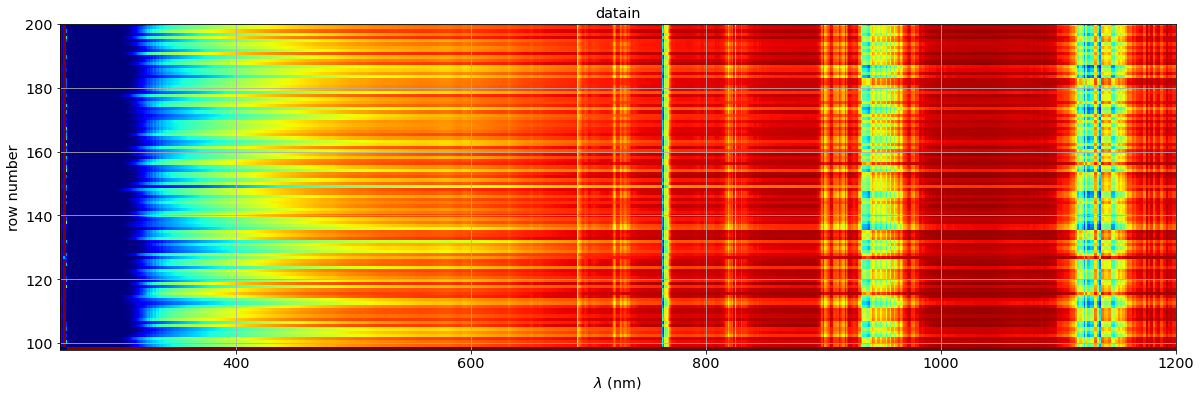

In [66]:
#if FLAG_PLOT:
if True:
    fig=plt.figure(figsize=(20,6))
    ax=fig.add_subplot(111)
    ax.imshow(datain,origin="lower",aspect="auto",interpolation="nearest",vmin=0,vmax=1,cmap='jet',extent=[wl.min(),wl.max(),NROWMIN-1,NROWMAX])
    ax.grid()
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("row number")
    ax.set_title("datain")

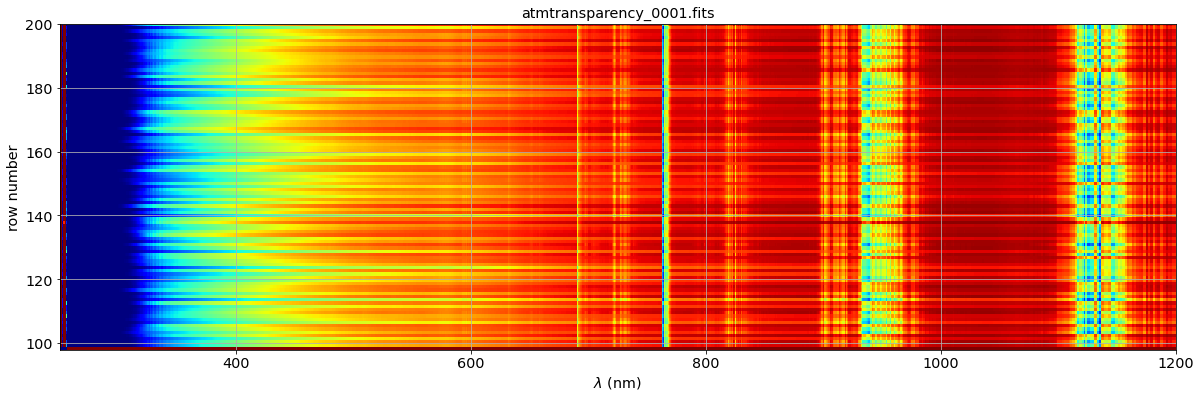

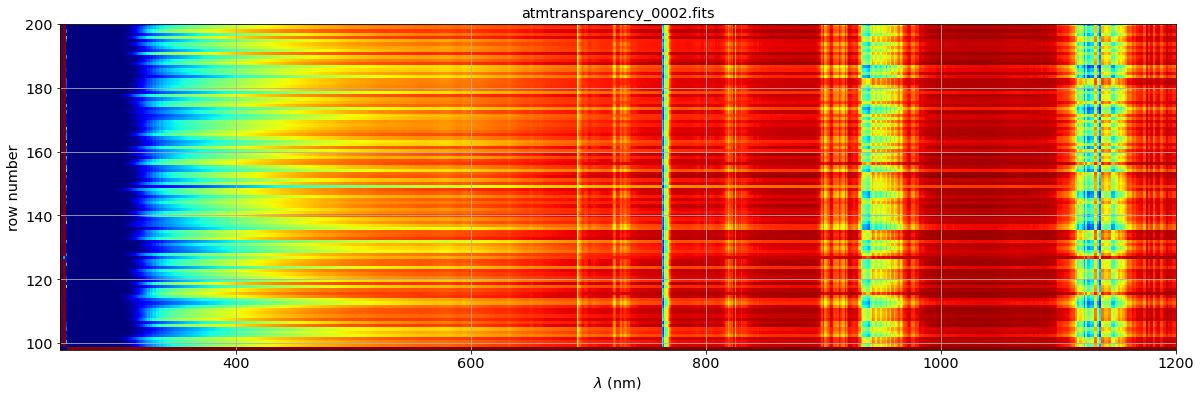

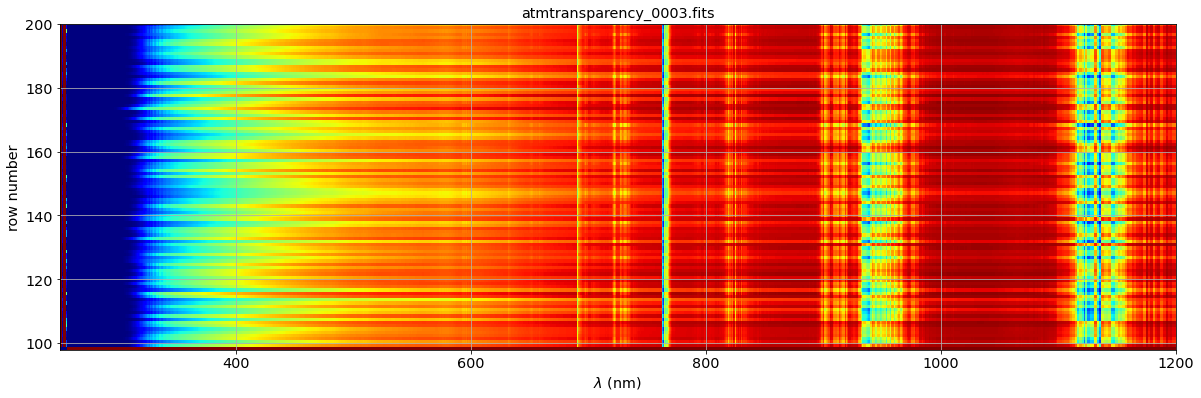

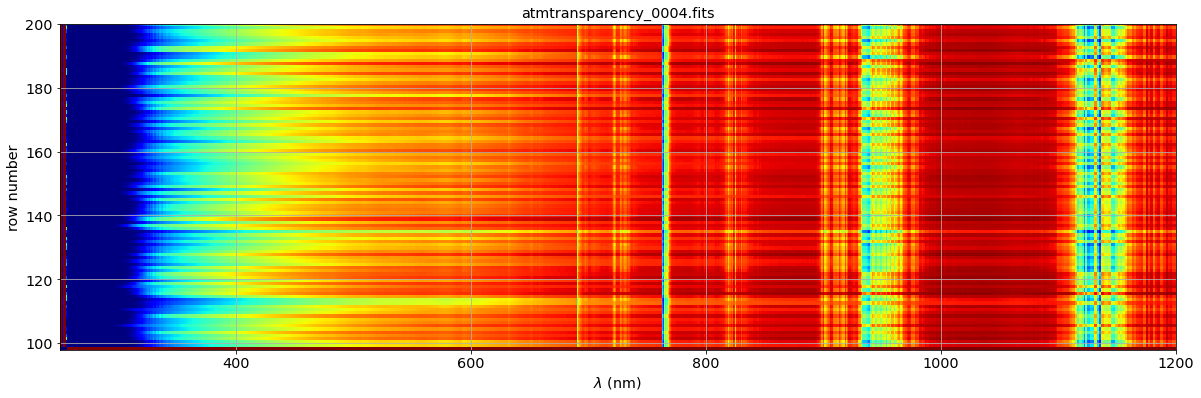

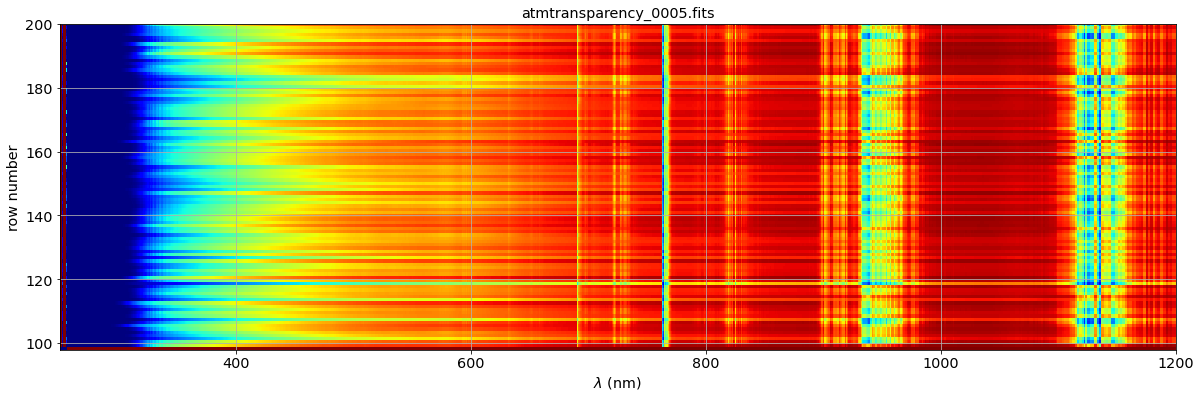

In [67]:
#if FLAG_PLOT:
if True:

    idx=0
    for file in selected_files:
        full_inputfilename=os.path.join(input_dir,file)
        hduin = fits.open(full_inputfilename)
        datain=hduin[0].data
    
        fig=plt.figure(figsize=(20,6))
        ax=fig.add_subplot(111)
        ax.imshow(datain,origin="lower",aspect="auto",interpolation="nearest",vmin=0,vmax=1,cmap='jet',extent=[wl.min(),wl.max(),NROWMIN-1,NROWMAX])
        ax.grid()
        ax.set_xlabel("$\lambda$ (nm)")
        ax.set_ylabel("row number")
        title=file
        ax.set_title(title)
        plt.show()
        idx+=1
        if(idx>4):
            break
            

In [68]:
N=NFiles
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=N)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

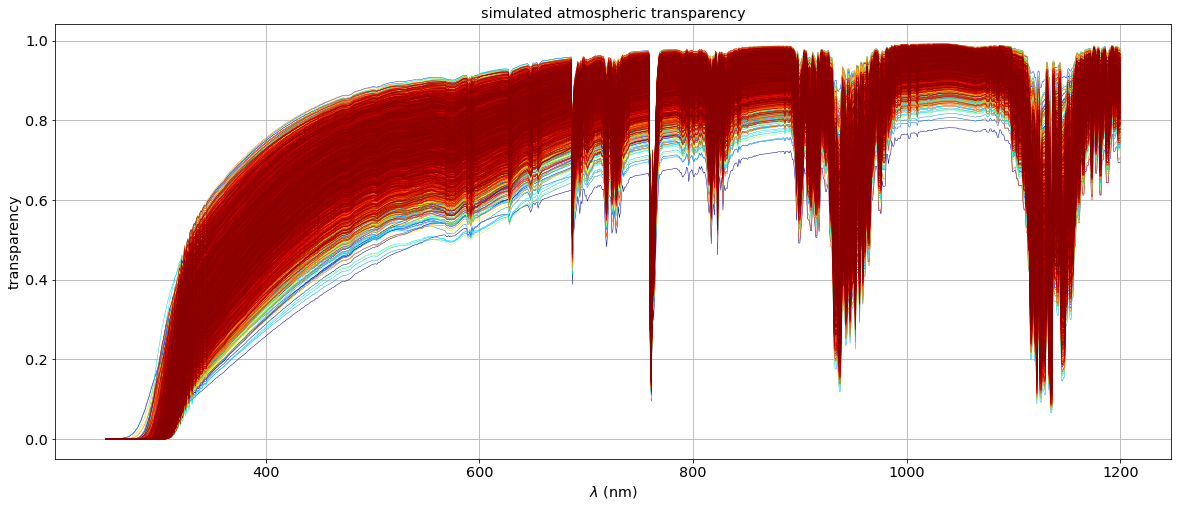

In [69]:
fig=plt.figure(figsize=(20,8))
ax=fig.add_subplot(111)

num=0
for file in selected_files:
    full_inputfilename=os.path.join(input_dir,file)
    hduin = fits.open(full_inputfilename)
    datain=hduin[0].data
    for idx in np.arange(datain.shape[0]-1):
        ax.plot(wl,datain[idx+1,idx_res:],color=all_colors[num],lw=0.5)
        
    num+=1
    
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("transparency")
ax.set_title("simulated atmospheric transparency")
ax.grid()
        

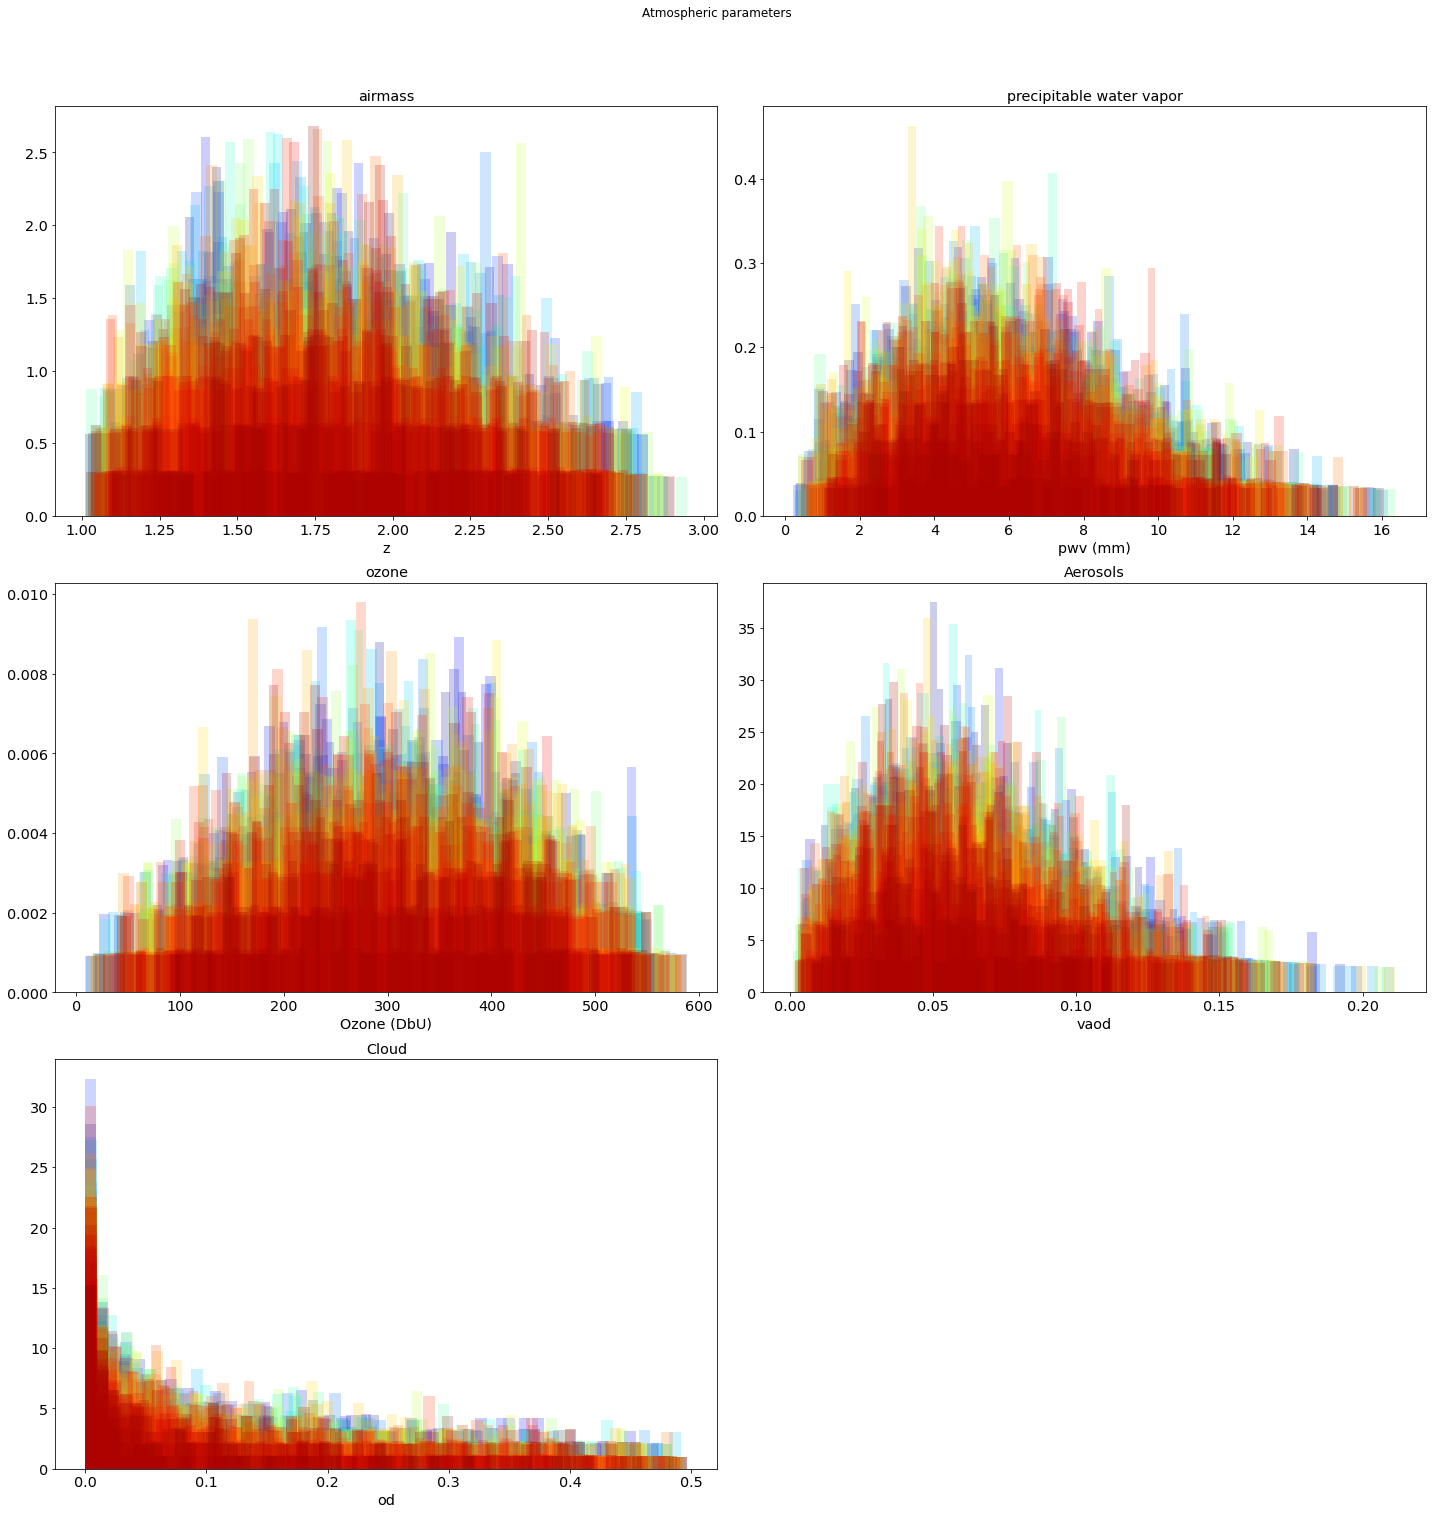

In [70]:
fig=plt.figure(figsize=(20,20))
ax1=fig.add_subplot(321)
ax2=fig.add_subplot(322)
ax3=fig.add_subplot(323)
ax4=fig.add_subplot(324)
ax5=fig.add_subplot(325)




all_am=np.zeros(NFiles)
all_pwv=np.zeros(NFiles)
all_aer=np.zeros(NFiles)
all_o3=np.zeros(NFiles)
all_cld=np.zeros(NFiles)

idx=0 
 
for file in selected_files:

    full_inputfilename=os.path.join(input_dir,file)
    hduin = fits.open(full_inputfilename)
    datain=hduin[0].data
    
    am= datain[1:,idx_am]
    pwv= datain[1:,idx_pwv]
    ozone= datain[1:,idx_o3]
    aer= datain[1:,idx_vaod]
    cloudext= datain[1:,idx_cld]
    
    ax1.hist(am,bins=50,facecolor=all_colors[idx],alpha=0.2,density=True);
    ax1.set_title("airmass")
    ax1.set_xlabel("z")
    ax2.hist(pwv,bins=50,facecolor=all_colors[idx],alpha=0.2,density=True);
    ax2.set_title("precipitable water vapor")
    ax2.set_xlabel("pwv (mm)")
    ax3.hist(ozone,bins=50,facecolor=all_colors[idx],alpha=0.2,density=True);
    ax3.set_title("ozone")
    ax3.set_xlabel("Ozone (DbU)")
    ax4.hist(aer,bins=50,facecolor=all_colors[idx],alpha=0.2,density=True);
    ax4.set_title("Aerosols")
    ax4.set_xlabel("vaod")
    ax5.hist(cloudext,bins=50,facecolor=all_colors[idx],alpha=0.2,density=True);
    ax5.set_title("Cloud")
    ax5.set_xlabel("od")
    
    
    hduin.close()
    
    idx+=1
plt.tight_layout()
plt.suptitle("Atmospheric parameters",Y=1.05)
plt.show()    